In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_all = pd.read_csv('yearly.csv')

In [7]:
# 한글 폰트 오류 방지
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


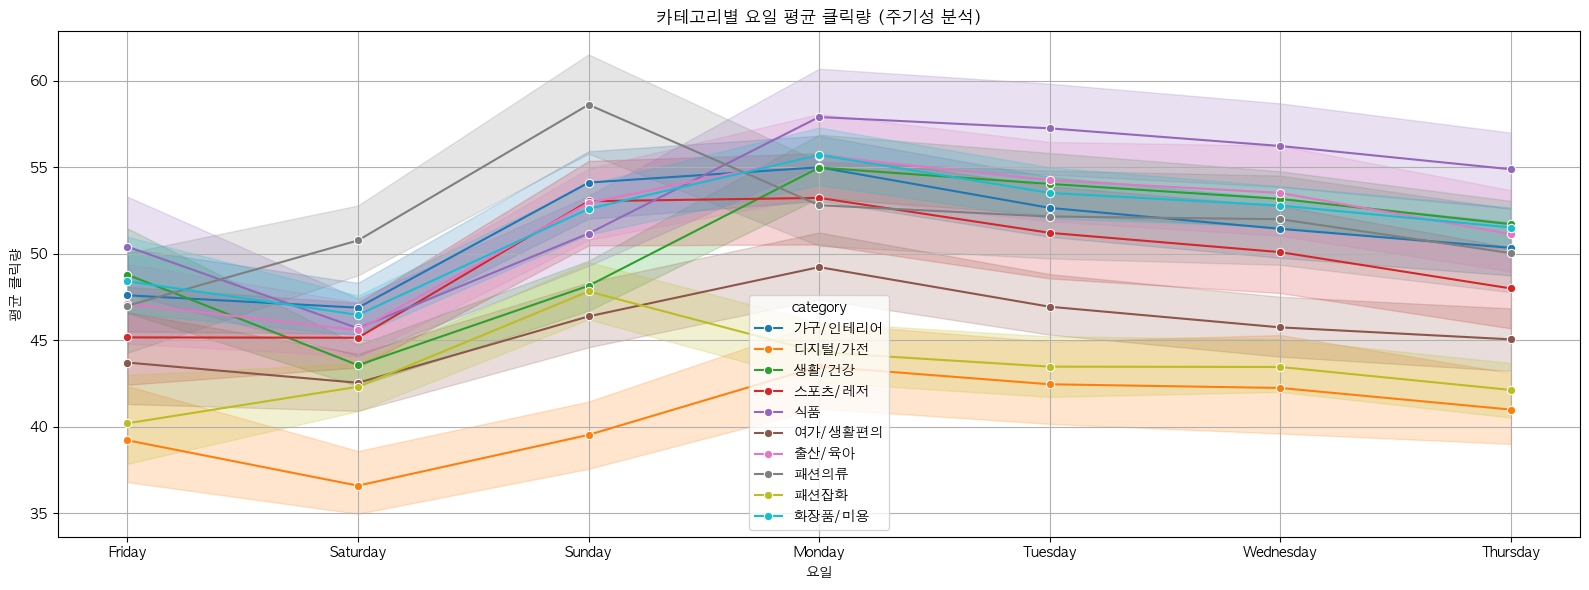

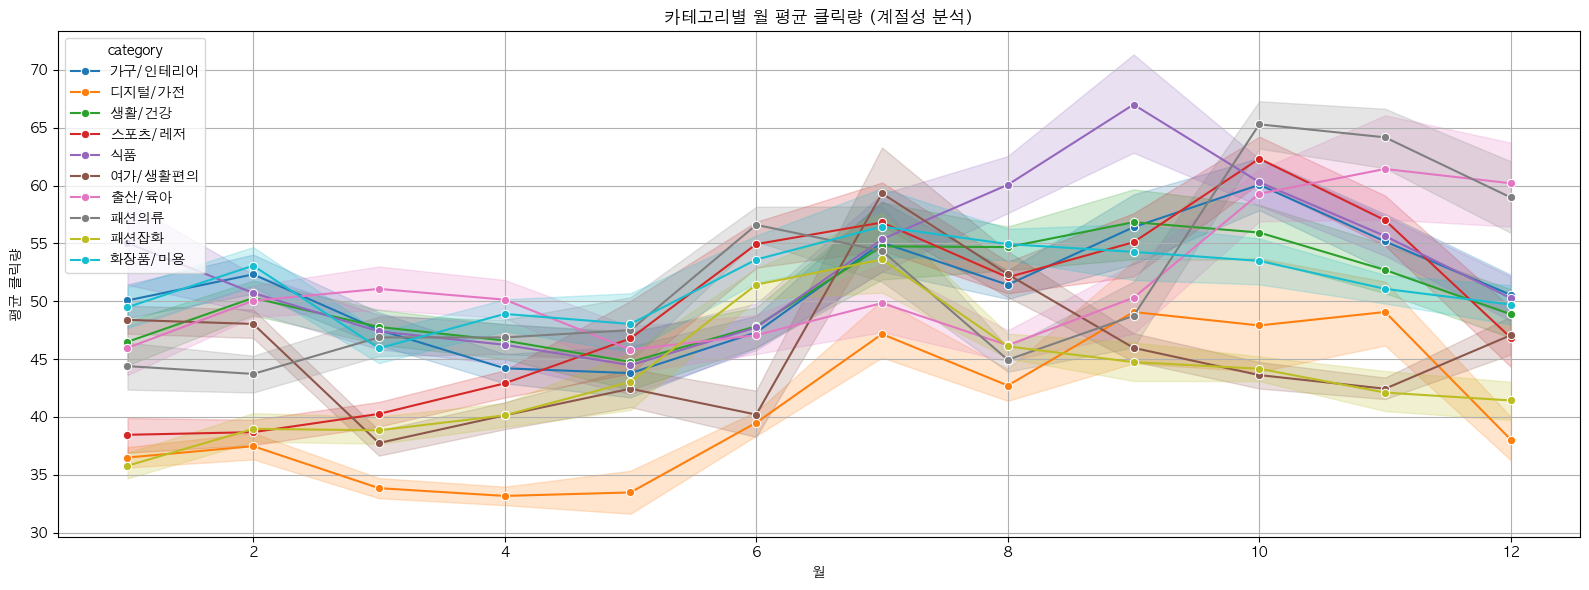

In [10]:

# 카테고리 목록 확인
categories = df_all['category'].unique()

# 요일별 주기성 시각화
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_all, x='weekday', y='click_volume', hue='category', estimator='mean', marker='o')
plt.title('카테고리별 요일 평균 클릭량 (주기성 분석)')
plt.xlabel('요일')
plt.ylabel('평균 클릭량')
plt.grid(True)
plt.tight_layout()
plt.show()

# 월별 계절성 시각화
plt.figure(figsize=(16, 6))
sns.lineplot(data=df_all, x='month', y='click_volume', hue='category', estimator='mean', marker='o')
plt.title('카테고리별 월 평균 클릭량 (계절성 분석)')
plt.xlabel('월')
plt.ylabel('평균 클릭량')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import plotly.express as px

# 데이터 로드
df = pd.read_csv("yearly.csv")
df['date'] = pd.to_datetime(df['date'])

# 요일 및 월 정보 생성
df['weekday'] = pd.Categorical(df['weekday'], 
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    ordered=True)
df['month'] = df['month'].astype(int)

# ✅ 요일별 주기성 시각화
weekday_avg = df.groupby(['category', 'weekday'])['click_volume'].mean().reset_index()

fig1 = px.line(
    weekday_avg,
    x='weekday',
    y='click_volume',
    color='category',
    markers=True,
    title='카테고리별 요일 평균 클릭량 추이'
)
fig1.update_layout(
    font=dict(family='Nanum Gothic', size=14),
    xaxis_title='요일',
    yaxis_title='평균 클릭량', 
    width=1000, height=600
)
fig1.show()

# ✅ 월별 계절성 시각화
month_avg = df.groupby(['category', 'month'])['click_volume'].mean().reset_index()

fig2 = px.line(
    month_avg,
    x='month',
    y='click_volume',
    color='category',
    markers=True,
    title='카테고리별 월 평균 클릭량 추이'
)
fig2.update_layout(
    font=dict(family='Nanum Gothic', size=14),
    xaxis_title='월',
    yaxis_title='평균 클릭량',
    width=1000, height=600
)
fig2.show()

/var/folders/27/g6rtkrj13t7g1gls17n1_tfr0000gn/T/ipykernel_34790/1142099690.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [16]:
import pandas as pd
import plotly.express as px

# 데이터 로드 및 전처리
df = pd.read_csv("yearly.csv")
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['month'].astype(int)

# 카테고리-월 별 평균 클릭량 계산
month_avg = df.groupby(['category', 'month'])['click_volume'].mean().reset_index()

# 카테고리별 정규화 (min-max scaling)
month_avg['norm_click'] = month_avg.groupby('category')['click_volume'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# 히트맵 시각화
fig = px.imshow(
    month_avg.pivot(index='category', columns='month', values='norm_click'),
    labels=dict(x="월", y="카테고리", color="정규화된 클릭량"),
    x=[f"{m}월" for m in sorted(df['month'].unique())],
    y=sorted(df['category'].unique()),
    aspect="auto",
    color_continuous_scale="YlGnBu",
    title="카테고리별 월별 클릭량 히트맵 (0~1 정규화)"
)

fig.update_layout(
    font=dict(family='Nanum Gothic', size=14),
    xaxis_title="월",
    yaxis_title="카테고리",
    width=1000, height=600
)
fig.show()

### prophet 기반 시계열 분해!

In [18]:
# pip install prophet plotly pandas

import pandas as pd
from prophet import Prophet
import plotly.express as px

# 1. 데이터 로딩
df = pd.read_csv("yearly.csv")
df['date'] = pd.to_datetime(df['date'])

# 2. Prophet 분해 결과 저장용 리스트
trend_all = []
weekly_all = []
yearly_all = []

# 3. 카테고리별 분해
for cat in df['category'].unique():
    df_cat = df[df['category'] == cat][['date', 'click_volume']].rename(columns={'date': 'ds', 'click_volume': 'y'})

    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.fit(df_cat)

    future = m.make_future_dataframe(periods=0)
    forecast = m.predict(future)

    # 추세
    trend_df = forecast[['ds', 'trend']].copy()
    trend_df['category'] = cat
    trend_all.append(trend_df)

    # 주간 주기성
    weekly = m.predict_seasonal_components(forecast)['weekly']
    weekly_df = pd.DataFrame({
        'ds': forecast['ds'],
        'value': weekly,
        'category': cat
    })
    weekly_all.append(weekly_df)

    # 연간 계절성
    yearly = m.predict_seasonal_components(forecast)['yearly']
    yearly_df = pd.DataFrame({
        'ds': forecast['ds'],
        'value': yearly,
        'category': cat
    })
    yearly_all.append(yearly_df)

# 4. 데이터 병합
trend_df = pd.concat(trend_all)
weekly_df = pd.concat(weekly_all)
yearly_df = pd.concat(yearly_all)

# 5. Plotly 시각화

# 추세
fig_trend = px.line(trend_df, x='ds', y='trend', color='category', title='📈 추세 (Trend)')
fig_trend.update_layout(font=dict(family='Nanum Gothic', size=14), xaxis_title='날짜', yaxis_title='추세')
fig_trend.show()

# 주간 주기성
fig_weekly = px.line(weekly_df, x='ds', y='value', color='category', title='📊 주간 주기성 (Weekly Seasonality)')
fig_weekly.update_layout(font=dict(family='Nanum Gothic', size=14), xaxis_title='날짜', yaxis_title='주간 효과')
fig_weekly.show()

# 연간 계절성
fig_yearly = px.line(yearly_df, x='ds', y='value', color='category', title='📆 연간 계절성 (Yearly Seasonality)')
fig_yearly.update_layout(font=dict(family='Nanum Gothic', size=14), xaxis_title='날짜', yaxis_title='연간 효과')
fig_yearly.show()

13:51:57 - cmdstanpy - INFO - Chain [1] start processing
13:51:57 - cmdstanpy - INFO - Chain [1] done processing
/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning:

divide by zero encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning:

overflow encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning:

invalid value encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1550: RuntimeWarning:

divide by zero encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1550: RuntimeWarning:

overflow encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1550: RuntimeWarning:

invalid value encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packag

In [19]:
# pip install prophet
import pandas as pd
from prophet import Prophet

# 데이터 불러오기
df = pd.read_csv("yearly.csv")
df['date'] = pd.to_datetime(df['date'])

# 결과 저장 리스트
results = []

# Prophet 분해
for cat in df['category'].unique():
    df_cat = df[df['category'] == cat][['date', 'click_volume']].rename(columns={'date': 'ds', 'click_volume': 'y'})

    m = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False)
    m.fit(df_cat)

    future = m.make_future_dataframe(periods=0)
    forecast = m.predict(future)

    forecast['category'] = cat
    results.append(forecast[['ds', 'trend', 'weekly', 'yearly', 'category']])

# 병합 및 저장
df_result = pd.concat(results)
df_result.to_csv("prophet_decomposed.csv", index=False)
print("✅ 'prophet_decomposed.csv' 저장 완료!")

14:01:15 - cmdstanpy - INFO - Chain [1] start processing
14:01:15 - cmdstanpy - INFO - Chain [1] done processing
/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning:

divide by zero encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning:

overflow encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1415: RuntimeWarning:

invalid value encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1550: RuntimeWarning:

divide by zero encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1550: RuntimeWarning:

overflow encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packages/prophet/forecaster.py:1550: RuntimeWarning:

invalid value encountered in matmul

/Users/swkim/datanote/search/lib/python3.13/site-packag

✅ 'prophet_decomposed.csv' 저장 완료!
